In [250]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import datetime
from matplotlib.colors import LinearSegmentedColormap

if Path.home().name == "nikolaibeckjensen":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"
elif Path.home().name == "annabramslow":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet(2)" / "Virk2Vec" / "data"

save_path = r'/Users/annabramslow/Desktop/Figurer - Deskriptiv Analyse'

In [251]:
plt.rcParams["grid.linestyle"] =  ":"
plt.rcParams["axes.edgecolor"] = "grey"
plt.rcParams["axes.linewidth"] = 0.7

#font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# **Firm Dynamics Analysis**

## **The Life of A Company**

This notebook serves to prepare figures for the written thesis based on the work first completed in the notebook "initial_analysis"


#### *Filtering the data*
For this analysis, we look at CVR-numbers who fulfill the following criteria:
- Has published 5 or more annual financial reports in the periode 2013-2023

In [28]:
def load_all_chunks_from_folder(folder) -> pd.DataFrame:
    df = pd.DataFrame()
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df_chunk = pd.read_csv(os.path.join(folder, file), index_col=0)
            df = pd.concat([df, df_chunk])

    return df
                                   

# load company info
company_info_folder = r'/Users/annabramslow/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet(2)/Virk2Vec/data/Tables/CompanyInfo'
company_info_full = load_all_chunks_from_folder(company_info_folder)

# load financials
financials_folder = r'/Users/annabramslow/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet(2)/Virk2Vec/xml_links'
financials = load_all_chunks_from_folder(financials_folder).dropna(subset=['CVR']).reset_index(drop=True)
financials['CVR'] = financials['CVR'].astype(int)

# get a list of CVR numbers with more than 2 reports
cvr_counts = financials['CVR'].value_counts()
cvr_list = cvr_counts[cvr_counts >= 2].index.to_list()

#filter out companies with less than 2 reports in company_info
company_info = company_info_full[company_info_full['CVR'].isin(cvr_list)].reset_index(drop=True)

del financials
del company_info_full


In [29]:
print("Number of companies with more than 2 reports: ", len(company_info))
print("Share of active companies:", company_info.EndDate.isna().sum()/len(company_info))

Number of companies with more than 2 reports:  420607
Share of active companies: 0.706904545097918


## Industry code

In [30]:
company_info = company_info.dropna(subset=['IndustryCode'])

In [31]:
company_info['IndustryCode'] = company_info.IndustryCode.astype(int).astype(str)
company_info['IndustryCode4'] = company_info['IndustryCode'].str[:4]
company_info['IndustryCode2'] = company_info['IndustryCode'].str[:2]

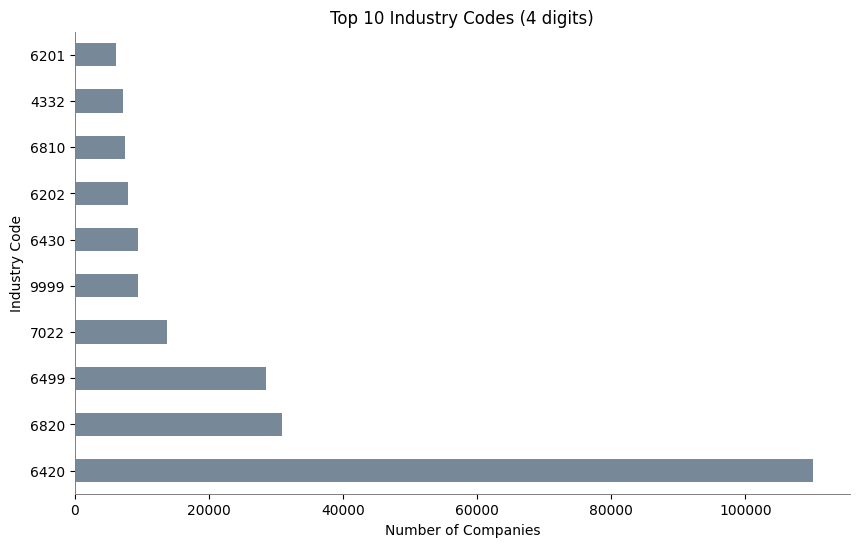

In [32]:
plt.figure(figsize=(10, 6))
company_info['IndustryCode4'].value_counts()[:10].plot(kind='barh', color='lightslategray')  # Swap 'bar' with 'barh' and add color argument
plt.xlabel('Number of Companies')
plt.ylabel('Industry Code')  # Swap x and y axis labels
plt.title('Top 10 Industry Codes (4 digits)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save fig
plt.savefig(os.path.join(save_path, 'Top10IndustryCodes.png'))

## Employees

In [33]:
# load the data
employee_folder = r'/Users/annabramslow/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet(2)/Virk2Vec/data/Tables/EmployeeCounts'
df_employee = load_all_chunks_from_folder(employee_folder)
print(len(df_employee))
df_employee['Year'] = df_employee.FromDate.str[:4]

# filter out companies with less than 5 reports
df_employee = df_employee[df_employee['CVR'].isin(cvr_list)].reset_index(drop=True)

14563505


In [34]:
# enrich company_info with the latest employee count
df_employee_latest = df_employee.sort_values('FromDate', ascending=False).groupby('CVR').first().reset_index().rename(columns={'EmployeeCounts': 'LatestEmployeeCount'})[['CVR', 'LatestEmployeeCount']]
company_info = company_info.merge(df_employee_latest, how='left', left_on='CVR', right_on='CVR')

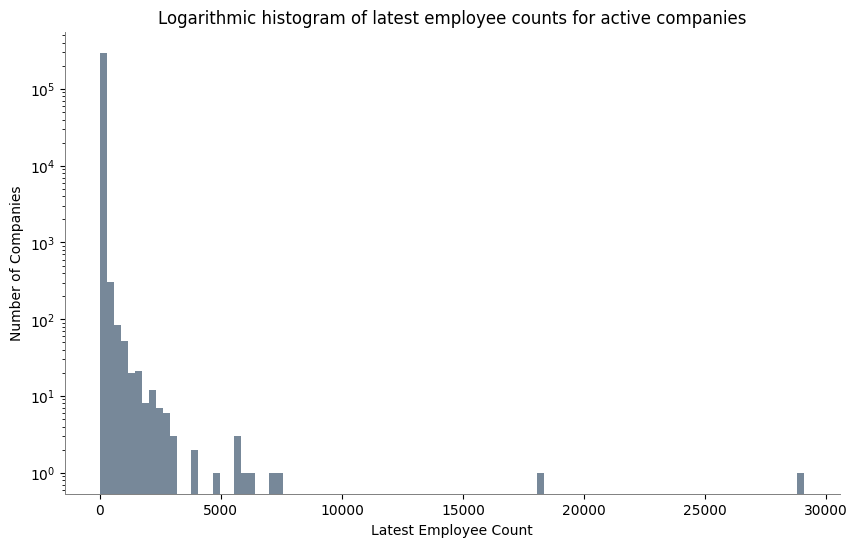

In [85]:
#fill nan values with 0
company_info['LatestEmployeeCount'] = company_info['LatestEmployeeCount'].fillna(0)

# now look only at the actve companies
company_info_active = company_info[(company_info.EndDate.isna())]

# plot the distribution of the latest employee counts
plt.figure(figsize=(10, 6))
company_info_active.LatestEmployeeCount.plot(kind='hist', bins=100, log=True, color='lightslategray')
plt.xlabel('Latest Employee Count')
plt.ylabel('Number of Companies')
plt.title('Logarithmic histogram of latest employee counts for active companies')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save fig
plt.savefig(os.path.join(save_path, 'LatestEmployeeCountHistogram.png'))

## **Understanding Bankruptcy and Other Firm Dynamics**

Filter CVR numbers - only include companies that at some point has been IVS, A/S or ApS

In [36]:
#cvr filter file
cvr_filter = DATA_ROOT / "Tables" / "CVRFiltered"
cvr_filter_files = [file for file in os.listdir(cvr_filter) if file.endswith('.csv')]
cvr_filter = pd.concat([pd.read_csv(os.path.join(cvr_filter, file), index_col=0) for file in cvr_filter_files])

In [37]:
# read all registration data
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])
industries = registrations.loc[registrations.ChangeType == 'Industry']
company_types = registrations.loc[registrations.ChangeType == 'CompanyType']
registrations = registrations.loc[registrations.ChangeType == 'Status']

In [38]:
# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
df_all = registrations.loc[registrations.ChangeType == 'Status']
registrations_target = registrations.loc[registrations.NewValue.isin(targets_all)]

tvang_registrations = registrations_target.loc[registrations_target.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations_target.loc[registrations_target.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate','NewValue']]

# merge the two dataframes
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations])
#df_bankrupt = df_bankrupt.rename(columns={'NewValue': 'bankrupt_type'})

# add the opløst efter konkurs
rest = registrations_target.loc[~registrations_target.CVR.isin(df_bankrupt.CVR)]
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]

# add the rest to the df_bankrupt
df_bankrupt_temp = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date'})

#group by CVR and get the earliest date for cases where a company has both 'tvangsopløst' and 'under konkurs'
df_bankrupt = df_bankrupt_temp.groupby('CVR').agg({'bankrupt_date': 'min'}).reset_index()

#join bankrupt type back to the df_bankrupt
df_bankrupt = df_bankrupt.merge(df_bankrupt_temp, on=['CVR', 'bankrupt_date'], how='left')

# correct df_all to not include the companies that are bankrupt
df_all = df_all.loc[~df_all.CVR.isin(df_bankrupt.CVR)][['CVR', 'FromDate']]

## Bankruptcy

## Difference in Bankruptcy targets

In [104]:
# load data 
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations_box = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
registrations_box = registrations_box.loc[registrations_box.ChangeType == 'Status']
registrations_box = registrations_box.loc[registrations_box.NewValue.isin(targets_all)]

tvang_registrations = registrations_box.loc[registrations_box.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations_box.loc[registrations_box.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate', 'NewValue']]

In [105]:
# assert no intersection between the two status types on CVR. 
intersect = set(tvang_registrations.CVR).intersection(set(u_konkurs_registrations.CVR))
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations]).sort_values('FromDate', ascending=True).drop_duplicates('CVR', keep='first')

# add the opløst efter konkurs
rest = registrations.loc[~registrations.CVR.isin(df_bankrupt.CVR)]
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]

df_bankrupt = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date', 'NewValue': 'bankrupt_type'})

In [106]:
finance_folder = DATA_ROOT / "Tables" / "Financials"
finance_files = [file for file in os.listdir(finance_folder) if file.endswith('.csv')]
financials_all = pd.concat([pd.read_csv(os.path.join(finance_folder, file), index_col=0) for file in finance_files])

# merge with bankrupt data
financials_all['PublicationYear'] = financials_all['PublicationDate'].str[:4].astype(int)
financials_all = financials_all.merge(df_bankrupt, left_on='CVR', right_on='CVR', how='left')
financials_all['BankruptYear'] = pd.to_numeric(financials_all.bankrupt_date.str[:4], errors='coerce')
financials_all['bankrupt_type'] = financials_all['bankrupt_type'].fillna('NOT BANKRUPT')

# format columns
financials_all['EmployeeBenefitsExpense'] = financials_all['EmployeeBenefitsExpense'].abs()
financials_all['ProfitLoss'] = pd.to_numeric(financials_all['ProfitLoss'], errors='coerce')

# filter out outliers in profitloss
financials_all = financials_all.loc[financials_all['ProfitLoss'] < 1e21]

financials_bankrupt = financials_all.loc[~financials_all['BankruptYear'].isna()]
financials_bankrupt = financials_bankrupt.loc[financials_bankrupt['BankruptYear'] > 2013]
financials_bankrupt['YearsToBankruptcy'] = financials_bankrupt['PublicationYear'] - financials_bankrupt['BankruptYear']

In [107]:
#only include companies in cvr_filter
financials_bankrupt = financials_bankrupt.loc[financials_bankrupt.CVR.isin(cvr_filter.CVR)]

In [108]:
#absolute values of liabilitiesotherthanprovisions
financials_bankrupt['LiabilitiesOtherThanProvisions'] = financials_bankrupt['LiabilitiesOtherThanProvisions'].abs()

In [109]:
#rename bankrupt type UNDER KONKURS to IN BANKRUPTCY and TVANGSOPLØST to FORCED DISSOLUTION
financials_bankrupt['bankrupt_type'] = financials_bankrupt['bankrupt_type'].replace('UNDER KONKURS', 'IN BANKRUPTCY')
financials_bankrupt['bankrupt_type'] = financials_bankrupt['bankrupt_type'].replace('TVANGSOPLØST', 'FORCED DISSOLUTION')

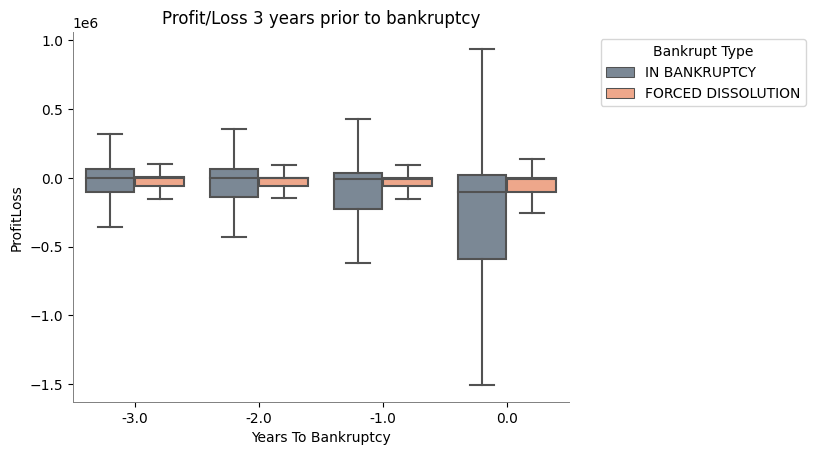

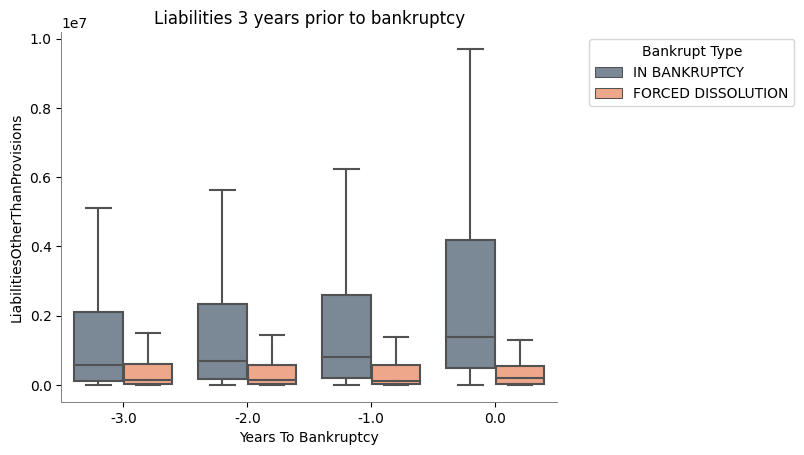

In [111]:
keys = ['ProfitLoss', 'LiabilitiesOtherThanProvisions']

for key in keys:
    prior3years = financials_bankrupt.loc[(financials_bankrupt['YearsToBankruptcy'] <= 0) & (financials_bankrupt['YearsToBankruptcy'] >= -3) & (financials_bankrupt['bankrupt_type'] != 'OPLØST EFTER KONKURS')]

    # only view companies with an annual report for all 3 years
    companies_with_3_reports = prior3years.CVR.value_counts() >= 3
    companies_with_3_reports = companies_with_3_reports[companies_with_3_reports].index
    prior3years = prior3years.loc[prior3years.CVR.isin(companies_with_3_reports)]
    
    # conditioning
    prior3years = prior3years.dropna(subset=[key])
    prior3years[key] = prior3years[key].astype(float)

    sns.boxplot(data=prior3years, x="YearsToBankruptcy", y=key, hue='bankrupt_type', hue_order=['IN BANKRUPTCY', 'FORCED DISSOLUTION'], showfliers=False, palette={'IN BANKRUPTCY': 'lightslategray', 'FORCED DISSOLUTION': 'lightsalmon'})
    plt.xlabel("Years To Bankruptcy")
    
    if key == 'ProfitLoss':
        plt.title("Profit/Loss 3 years prior to bankruptcy")
    elif key == 'LiabilitiesOtherThanProvisions':
        plt.title("Liabilities 3 years prior to bankruptcy")
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Move the legend outside the plot
    plt.legend(title='Bankrupt Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

### Bankruptcy across company types

In [46]:
registrations_filtered = registrations.loc[registrations.CVR.isin(cvr_filter.CVR)]

# creat year column but cutting first 4 characters from FromDate
registrations_filtered['year'] = registrations_filtered.FromDate.str[:4]

#drop rows with nan year and convert year to int
registrations_filtered = registrations_filtered.dropna(subset=['year'])

registrations_filtered['year'] = registrations_filtered['year'].astype(int)

# Prepare the data
df_bankrupt = df_bankrupt.rename(columns={'NewValue': 'bankrupt_type'})
df_bankrupt['bankrupt_date'] = pd.to_datetime(df_bankrupt['bankrupt_date'])
df_bankrupt['year'] = df_bankrupt['bankrupt_date'].dt.year
df_bankrupt = df_bankrupt.loc[df_bankrupt.CVR.isin(cvr_filter.CVR)]
df_bankrupt_hist = df_bankrupt.loc[(df_bankrupt.year >= 2013)&(df_bankrupt.year <= 2023)]

/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/2534400889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registrations_filtered['year'] = registrations_filtered.FromDate.str[:4]


In [47]:
print("No. of unique companies (with min 2 audit reports + correct company type): ", registrations_filtered.CVR.nunique())

No. of unique companies (with min 2 audit reports + correct company type):  410863


In [48]:
#convert company types to datetime
company_types['FromDate'] = pd.to_datetime(company_types['FromDate'])

#sort the dataframes
df_bankrupt_hist = df_bankrupt_hist.sort_values('bankrupt_date')
company_types = company_types.sort_values('FromDate')

#create a merge as of to get the company type at the time of bankruptcy
df_bank_comp = pd.merge_asof(df_bankrupt_hist, company_types, left_on='bankrupt_date', right_on='FromDate', by='CVR',direction='nearest')
#drop and rename columns
df_bank_comp = df_bank_comp.drop(columns=['FromDate', 'ChangeType']).rename(columns={'NewValue': 'company_type'})

<Figure size 1200x600 with 0 Axes>

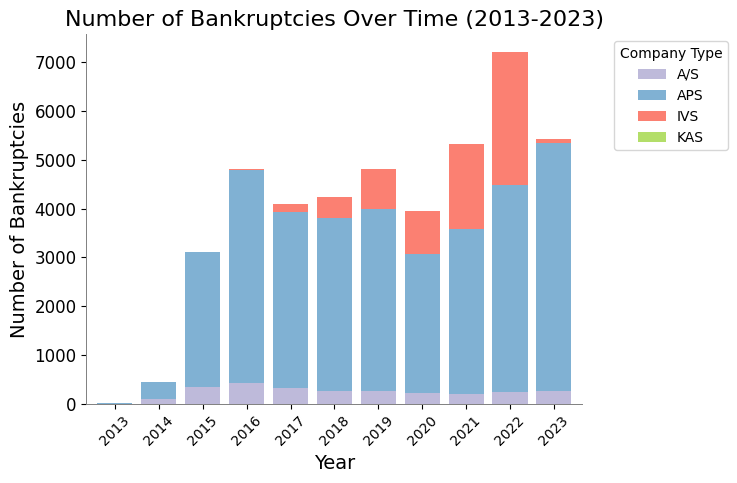

In [49]:
# Define a fixed color library for the company types using sns Set2 palette
color_palette = sns.color_palette("Set3", n_colors=10)

color_library = {
    'I/S': color_palette[0],  # First color in Set2
    'EFO': color_palette[1],  # Second color in Set2
    'A/S': color_palette[2],  # Third color in Set2
    'IVS': color_palette[3],  # Fourth color in Set2
    'APS': color_palette[4],  # Fifth color in Set2
    'ABA': color_palette[5],  # Sixth color in Set2
    'KAS': color_palette[6],  # Seventh color in Set2
    'FMA': color_palette[7],  # Eighth color in Set2
    'K/S': color_palette[8],  # Ninth color in Set2
    'SMA': color_palette[9],  # Tenth color in Set2
}

# Create a pivot table to get counts of each company type per year
stacked_data = df_bank_comp.pivot_table(index='year', columns='company_type', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(12, 6))
ax = stacked_data.plot(kind='bar', stacked=True, color=colors, width=0.8)

# Set titles and labels
plt.title('Number of Bankruptcies Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Move the legend outside the plot
plt.legend(title='Company Type', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

### Bankruptcy across industries

In [52]:
#convert industries date to datetime
industries['FromDate'] = pd.to_datetime(industries['FromDate'])

#sort the dataframes
df_bankrupt_hist = df_bankrupt_hist.sort_values('bankrupt_date')
industries = industries.sort_values('FromDate')

#create a merge as of to get the company type at the time of bankruptcy
df_bank_indu = pd.merge_asof(df_bankrupt_hist, industries, left_on='bankrupt_date', right_on='FromDate', by='CVR',direction='nearest')
#drop and rename columns
df_bank_indu = df_bank_indu.drop(columns=['FromDate', 'ChangeType']).rename(columns={'NewValue': 'industry_code'})

In [53]:
#create categories for the industries

industry_dict = {1: 'Agriculture, forestry, and fishing',
                 2: 'Industry, extraction of raw materials, and utilities',
                 3: 'Construction',
                 4: 'Trade and transport',
                 5: 'Information and communication',
                 6: 'Financing and insurance',
                 7: 'Real estate and leasing',
                 8: 'Business services',
                 9: 'Public administration, education, and health',
                 10: 'Culture, leisure, and other services',
                 11: 'Unspecified activities'}

def compute_industry_category(industry_code):
    if int(industry_code[:2]) < 5:
        return 1
    elif int(industry_code[:2]) < 41:
        return 2
    elif int(industry_code[:2]) < 45:
        return 3
    elif int(industry_code[:2]) < 58:
        return 4
    elif int(industry_code[:2]) < 64:
        return 5
    elif int(industry_code[:2]) < 68:
        return 6
    elif int(industry_code[:2]) < 69:
        return 7
    elif int(industry_code[:2]) < 84:
        return 8
    elif int(industry_code[:2]) < 99:
        return 9
    elif int(industry_code[:2]) <= 99 and industry_code != 999999:
        return 10
    else:
        return 11
    
#map industry code to industry category
df_bank_indu['short_industry_code'] = df_bank_indu['industry_code'].apply(lambda x: compute_industry_category(x))

<Figure size 1200x600 with 0 Axes>

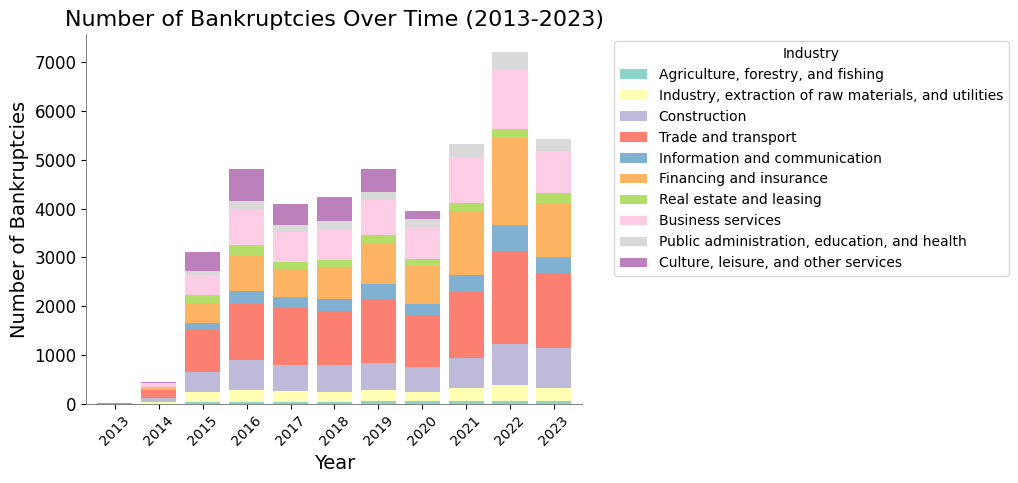

In [54]:
# Create a pivot table to get counts of each company type per year
stacked_data = df_bank_indu.pivot_table(index='year', columns='short_industry_code', aggfunc='size', fill_value=0)

# Match the color library with the company types in the dataset
#colors = [color_library.get(c, '#1f77b4') for c in stacked_data.columns]

# Plot as a stacked bar chart
plt.figure(figsize=(12, 6))
ax = stacked_data.plot(kind='bar', stacked=True, color=sns.color_palette("Set3"), width=0.8)

# Set titles and labels
plt.title('Number of Bankruptcies Over Time (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Bankruptcies', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Move the legend outside the plot
# use industry_dict to get the industry names
plt.legend(title='Industry', labels=[industry_dict.get(i, 'Unknown') for i in stacked_data.columns], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Company Age

In [35]:
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

In [36]:
#load company info to find company birthdate
companyinfo_folder = DATA_ROOT / "Tables" / "CompanyInfo"
companyinfo_files = [file for file in os.listdir(companyinfo_folder) if file.endswith('.csv')]
company_info = pd.concat([pd.read_csv(os.path.join(companyinfo_folder, file), index_col=0) for file in companyinfo_files])

In [55]:
#join the two dataframes and compute company age
df_bank_age = pd.merge(df_bankrupt, company_info[['CVR', 'StartDate']], on='CVR', how='left')

#convert dates to datetime
df_bank_age['StartDate'] = pd.to_datetime(df_bank_age['StartDate'])
df_bank_age['bankrupt_date'] = pd.to_datetime(df_bank_age['bankrupt_date'])

#compute company age
df_bank_age['company_age'] = (df_bank_age['bankrupt_date'] - df_bank_age['StartDate']).dt.days / 365

#drop rows with negative company age and nan
df_bank_age = df_bank_age.loc[df_bank_age.company_age >= 0]

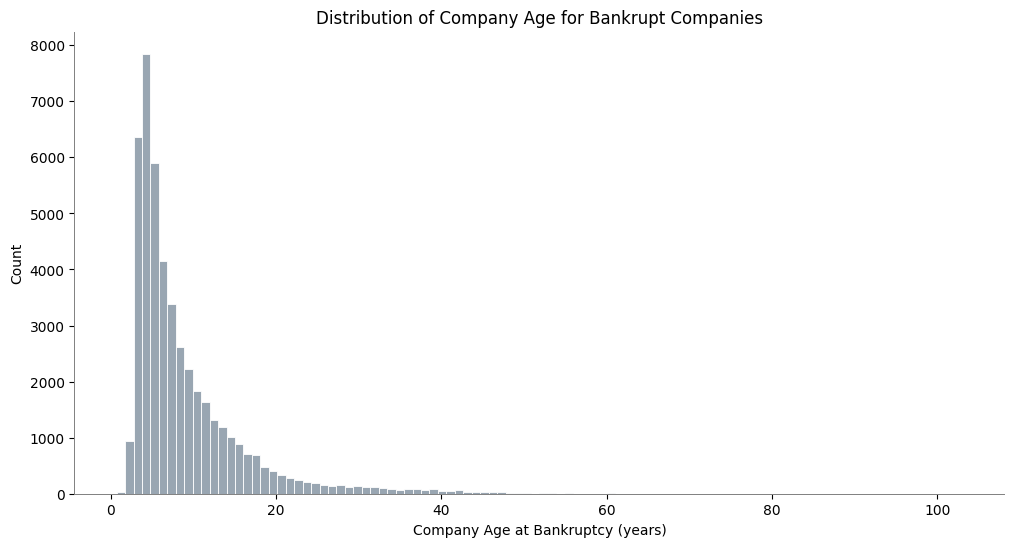

In [56]:
#plot the distribution of company age for bankrupt companies
plt.figure(figsize=(12, 6))
sns.histplot(df_bank_age['company_age'], bins=100, color='lightslategray', edgecolor='white')
plt.title('Distribution of Company Age for Bankrupt Companies')
plt.xlabel('Company Age at Bankruptcy (years)')
plt.ylabel('Count')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Moving

In [64]:
#load registrations data, filter on company relocations
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])
relocations = registrations.loc[registrations.ChangeType == 'Municipality']
#filter companies not in cvr_filter
relocations = relocations.loc[relocations.CVR.isin(cvr_filter.CVR)]

#filter on dates
relocations['FromDate'] = pd.to_datetime(relocations['FromDate'])
relocations = relocations.loc[(relocations.FromDate.dt.year >= 2013) & (relocations.FromDate.dt.year <= 2023)]

In [70]:
relocations

,CVR,FromDate,ChangeType,NewValue
11,34083150,2016-11-14,Municipality,101
12,34083150,2018-10-31,Municipality,101
28,27358128,2014-05-08,Municipality,400
29,27358128,2017-11-26,Municipality,370
64,27215416,2016-08-04,Municipality,740
...,...,...,...,...
83581,40810102,2020-01-30,Municipality,813
83589,41019603,2019-12-17,Municipality,101
83590,41019603,2021-06-30,Municipality,173
83591,41019603,2023-03-13,Municipality,173


In [75]:
#load employee data
employee_folder = DATA_ROOT / "Tables" / "EmployeeCounts"
employee_files = [file for file in os.listdir(employee_folder) if file.endswith('.csv')]
employee = pd.concat([pd.read_csv(os.path.join(employee_folder, file), index_col=0) for file in employee_files])
employee['FromDate'] = pd.to_datetime(employee['FromDate'])
#drop changetype column
employee = employee.drop(columns=['ChangeType'])

In [77]:
#left join employee data with relocations data on as of date
#sort the dataframes
relocations = relocations.sort_values('FromDate')
employee = employee.sort_values('FromDate')

relocations_employee = pd.merge_asof(relocations, employee, on='FromDate', by='CVR', direction='nearest')


In [95]:
#fill missing values with 0
relocations_employee = relocations_employee.fillna(0)

#assign a new column with a category for the number of employees (0 or >0)
relocations_employee['zero_employees'] = relocations_employee['EmployeeCounts'].apply(lambda x: 1 if x == 0 else 0)

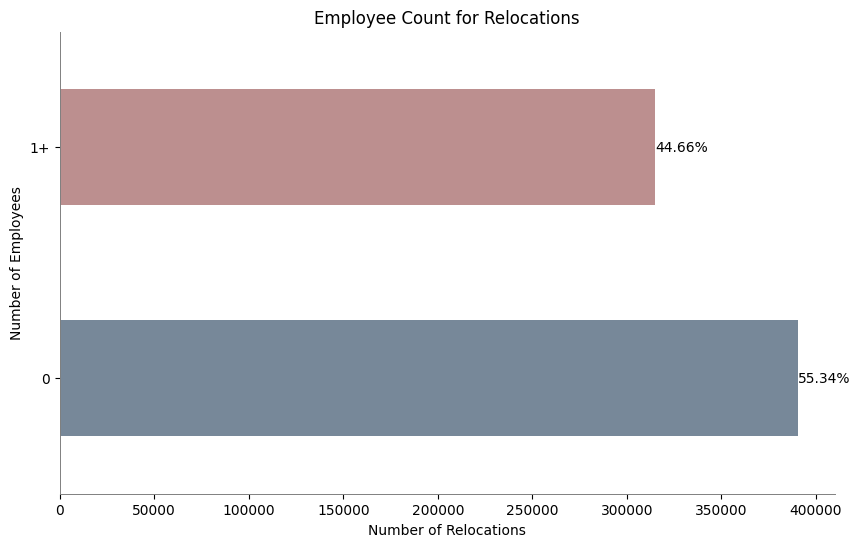

In [103]:
# Calculate normalized value counts
normalized_counts = relocations_employee.zero_employees.value_counts(normalize=True)

# Plot value counts of zero employees vs. >0 employees for companies relocating horizontally with a bar plot
plt.figure(figsize=(10, 6))
bars = relocations_employee.zero_employees.value_counts().plot(kind='barh', color=['lightslategray', 'rosybrown'])
plt.title('Employee Count for Relocations')
plt.xlabel('Number of Relocations')
plt.ylabel('Number of Employees')
ax = plt.gca()
ax.set_yticklabels(['0', '1+'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend with normalized values
for bar, value in zip(bars.patches, normalized_counts):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, f'{value:.2%}', va='center')

#plt.legend(['0 Employees', '>0 Employees'], title='Employee Count')
plt.show()


## Employees

In [244]:
# load data for employee counts
employee_folder = DATA_ROOT / "Tables" / "EmployeeCounts"
employee_files = [file for file in os.listdir(employee_folder) if file.endswith('.csv')]
employees = pd.concat([pd.read_csv(os.path.join(employee_folder, file), index_col=0) for file in employee_files])

# filter out companies not in cvr_filter
employees = employees.loc[employees.CVR.isin(cvr_filter.CVR)]

In [245]:
employees['Year'] = employees['FromDate'].str[:4].astype(int)
employees = employees.groupby(['CVR','Year']).mean().reset_index()

In [246]:
#load data for financials
finance_folder = DATA_ROOT / "Tables" / "Financials"
finance_files = [file for file in os.listdir(finance_folder) if file.endswith('.csv')]
financials_all = pd.concat([pd.read_csv(os.path.join(finance_folder, file), index_col=0) for file in finance_files])

#filter out companies not in cvr_filter
financials_all = financials_all.loc[financials_all.CVR.isin(cvr_filter.CVR)]

# merge with bankrupt data and employee data
financials_all['PublicationYear'] = financials_all['PublicationDate'].str[:4].astype(int)
financials_all = financials_all.merge(employees, left_on=['CVR', 'PublicationYear'], right_on=['CVR', 'Year'], how='left')

In [247]:
# format columns
financials_all['EmployeeBenefitsExpense'] = financials_all['EmployeeBenefitsExpense'].abs()
financials_all['Assets'] = financials_all['EmployeeBenefitsExpense'].abs()
financials_all['ProfitLoss'] = pd.to_numeric(financials_all['ProfitLoss'], errors='coerce')

# filter out outliers in profitloss
financials_all = financials_all.loc[financials_all['ProfitLoss'] < 1e21]

#fill nan values with 0 for employee counts
financials_all['EmployeeCounts'] = financials_all['EmployeeCounts'].fillna(0)


### Viz 1: Increasing Profits As Employee Counts Grow (for smaller companies)
- subset: 0-10 employees
- profitloss between -10 mio -> 10 mio
- Profitloss from annual reports across 2013-2023 versus the mean employee count of the company in the year of publication.

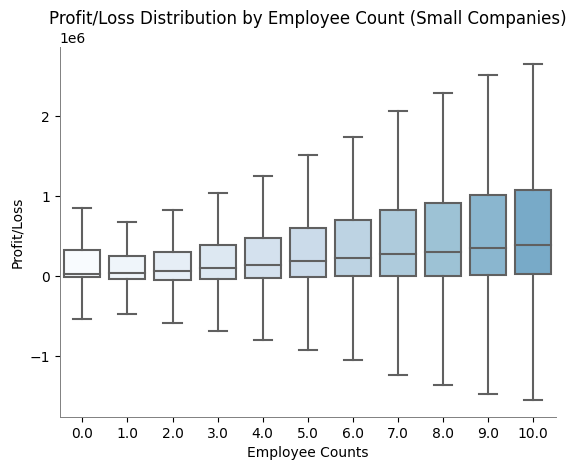

In [248]:
financials_all['EmployeeCountsInt'] = np.round(financials_all['EmployeeCounts'])
# Apply symmetric log transformation to the ProfitLoss column
employee_range = (0, 10)
profitloss_range = (-1e8, 1e8)
subset = financials_all.loc[(financials_all.ProfitLoss > profitloss_range[0]) & (financials_all.ProfitLoss < profitloss_range[1]) & (financials_all.EmployeeCounts >= employee_range[0]) & (financials_all.EmployeeCounts < employee_range[1])]

# Define color palette
blues_cmap = sns.color_palette("Blues", as_cmap=True)
blues_half = LinearSegmentedColormap.from_list("blues_half", blues_cmap(np.linspace(0, 0.5, 256)))

# Create a discrete palette from the colormap
num_categories = subset['EmployeeCountsInt'].nunique()
palette = [blues_half(i / (num_categories - 1)) for i in range(num_categories)]

sns.boxplot(data=subset, x='EmployeeCountsInt', y='ProfitLoss', showfliers=False, palette=palette)
plt.xlabel('Employee Counts')
plt.ylabel('Profit/Loss')
plt.title('Profit/Loss Distribution by Employee Count (Small Companies)')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Viz 2: Increasing Profits As Employee Counts Grow (for larger companies)
- subset: 0-10 employees
- profitloss between -10 mia -> 10 mia
- Profitloss from annual reports across 2013-2023 versus the mean employee count of the company in the year of publication.

/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/2508786542.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['EmployeeCountsBin'] = pd.cut(subset['EmployeeCounts'], bins=bins, labels=bin_names)


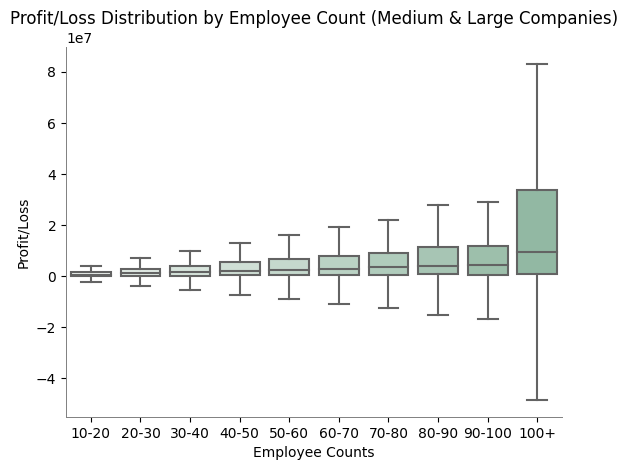

In [249]:
employee_range = (10,np.inf)
profitloss_range = (-1e10, 1e10)
subset = financials_all.loc[(financials_all.ProfitLoss > profitloss_range[0]) & (financials_all.ProfitLoss < profitloss_range[1]) & (financials_all.EmployeeCounts >= employee_range[0]) & (financials_all.EmployeeCounts < employee_range[1])]

# create a column with custom bins
bin_names = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
subset['EmployeeCountsBin'] = pd.cut(subset['EmployeeCounts'], bins=bins, labels=bin_names)

# Define color palette
greens_cmap = sns.light_palette("seagreen", as_cmap=True)
greens_half = LinearSegmentedColormap.from_list("greens_half", greens_cmap(np.linspace(0, 0.5, 256)))

# Create a discrete palette based on the number of bins
num_bins = len(bin_names)
palette = [greens_half(i / (num_bins - 1)) for i in range(num_bins)]

sns.boxplot(data=subset, x='EmployeeCountsBin', y='ProfitLoss', showfliers=False, palette=palette)
plt.xlabel('Employee Counts')
plt.ylabel('Profit/Loss')
plt.title('Profit/Loss Distribution by Employee Count (Medium & Large Companies)')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Capital Increase

### Age Distribution for Investments

In [176]:
folder = DATA_ROOT / "Tables" / "CapitalChanges"
files = [file for file in os.listdir(folder) if file.endswith('.csv')]
capital_all = pd.concat([pd.read_csv(os.path.join(folder, file), index_col=0, lineterminator='\n') for file in files])
#filter out companies not in cvr_filter
capital_all = capital_all.loc[capital_all.CVR.isin(cvr_filter.CVR)]

#convert dates to datetime
capital_all['Date'] = pd.to_datetime(capital_all['Date'])
#filter on dates from 2013 to 2023
capital_all = capital_all.loc[(capital_all.Date.dt.year >= 2013) & (capital_all.Date.dt.year <= 2023)]

/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/4294498018.py:8: UserWarning: Parsing '20-05-2008' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  capital_all['Date'] = pd.to_datetime(capital_all['Date'])
/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/4294498018.py:8: UserWarning: Parsing '24-04-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  capital_all['Date'] = pd.to_datetime(capital_all['Date'])
/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/4294498018.py:8: UserWarning: Parsing '20-11-2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  capital_all['Date'] = pd.to_datetime(capital_all['Date'])
/var/folders/18/tx_vvd811j166hznznnvx7sm0000gn/T/ipykernel_3569/4294498018.py:8: UserWarning: Parsing '29-12-1995' in DD/MM/YYYY format. Provide format or specify infer_datetime_

In [177]:
#compute true investment based on investment value and rate
capital_all['Investment'] = capital_all['InvestmentDKK']*(capital_all['Rate'] / 100)

In [184]:
#load company info to get company start date
companyinfo_folder = DATA_ROOT / "Tables" / "CompanyInfo"
companyinfo_files = [file for file in os.listdir(companyinfo_folder) if file.endswith('.csv')]
company_info = pd.concat([pd.read_csv(os.path.join(companyinfo_folder, file), index_col=0) for file in companyinfo_files])
#filter out companies not in cvr_filter
company_info = company_info.loc[company_info.CVR.isin(cvr_filter.CVR)]
#convert dates to datetime
company_info['StartDate'] = pd.to_datetime(company_info['StartDate'])

In [185]:
#left join company info with capital changes
df_capital = pd.merge(capital_all, company_info[['CVR', 'StartDate']], on='CVR', how='left')

In [186]:
#compute company age
df_capital['company_age'] = (df_capital['Date'] - df_capital['StartDate']).dt.days / 365

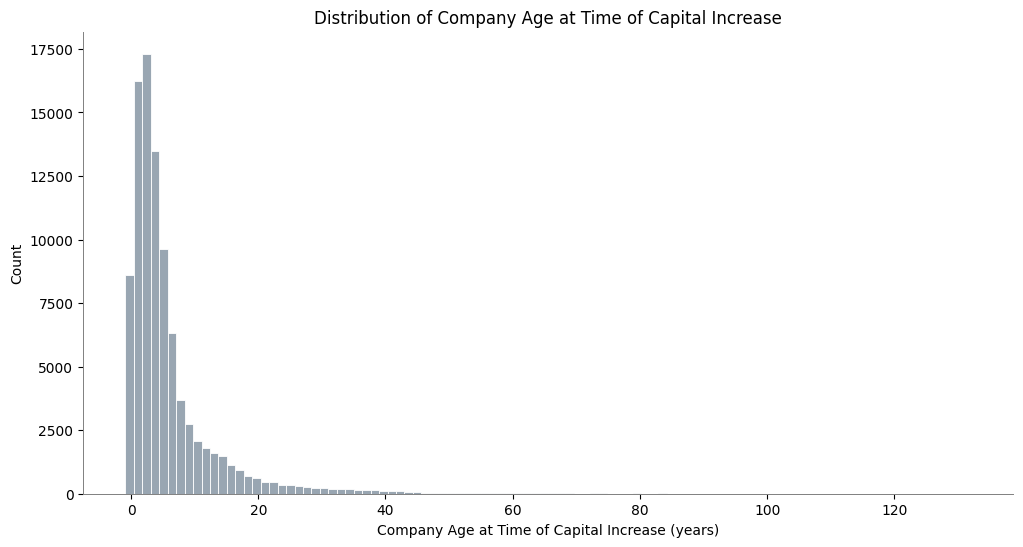

In [190]:
#plot the distribution of company age at time of investment
plt.figure(figsize=(12, 6))
sns.histplot(df_capital['company_age'], bins=100, color='lightslategray', edgecolor='white')
plt.title('Distribution of Company Age at Time of Capital Increase')
plt.xlabel('Company Age at Time of Capital Increase (years)')
plt.ylabel('Count')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Investment size - does it correlate with other measures?

In [198]:
#load financials data
finance_folder = DATA_ROOT / "Tables" / "Financials"
finance_files = [file for file in os.listdir(finance_folder) if file.endswith('.csv')]
financials_all = pd.concat([pd.read_csv(os.path.join(finance_folder, file), index_col=0) for file in finance_files])
#filter out companies not in cvr_filter
financials_all = financials_all.loc[financials_all.CVR.isin(cvr_filter.CVR)]
#covert cvr to int64
financials_all['CVR'] = financials_all['CVR'].astype(int)

In [199]:
#convert dates to datetime
financials_all['PublicationDate'] = pd.to_datetime(financials_all['PublicationDate'])

In [202]:
#merge as of to get the financials at the time of investment
capital_all = capital_all.sort_values('Date')
financials_all = financials_all.sort_values('PublicationDate')
df_cap_fin = pd.merge_asof(capital_all, financials_all, left_on='Date', right_on='PublicationDate', by='CVR', direction='nearest')

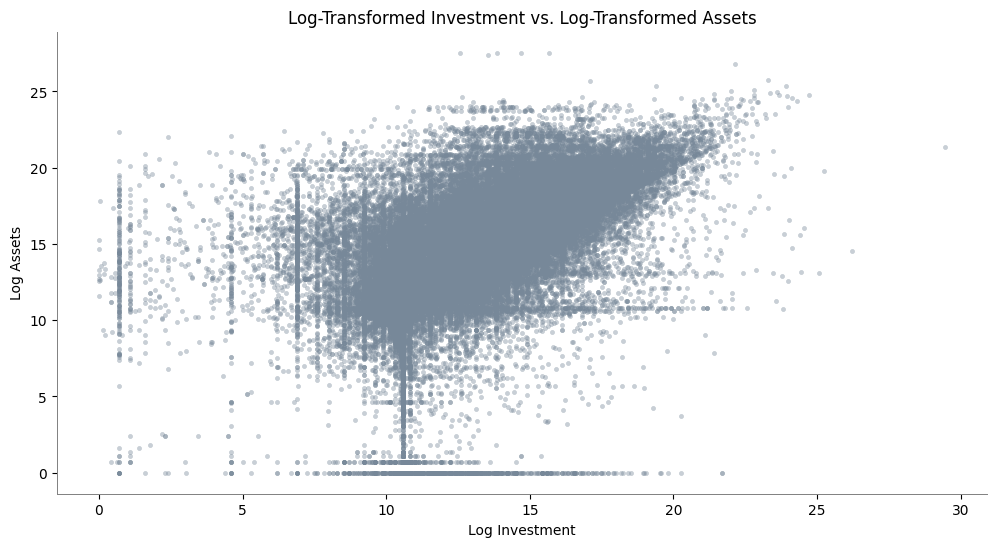

In [242]:
#scatter plot of log-transformed investment vs log-transformed assets
plt.figure(figsize=(12, 6))

investment_range = (0, 1e11)
assets_range = (0, 1e11)

#subset = df_cap_fin.loc[(df_cap_fin.Investment >= investment_range[0]) & (df_cap_fin.Investment <= investment_range[1]) & (df_cap_fin.Assets >= assets_range[0]) & (df_cap_fin.Assets <= assets_range[1])]
subset = df_cap_fin

# Apply natural log transformation
subset['LogInvestment'] = np.log(subset['Investment'] + 1)  # Adding 1 to avoid log(0)
subset['LogAssets'] = np.log(subset['Assets'] + 1)  # Adding 1 to avoid log(0)

sns.scatterplot(data=subset, x='LogInvestment', y='LogAssets', color='lightslategray', edgecolor=None, alpha=0.4, s=10)  # Adjust the 's' parameter to change point size
plt.title('Log-Transformed Investment vs. Log-Transformed Assets')
plt.xlabel('Log Investment')
plt.ylabel('Log Assets')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


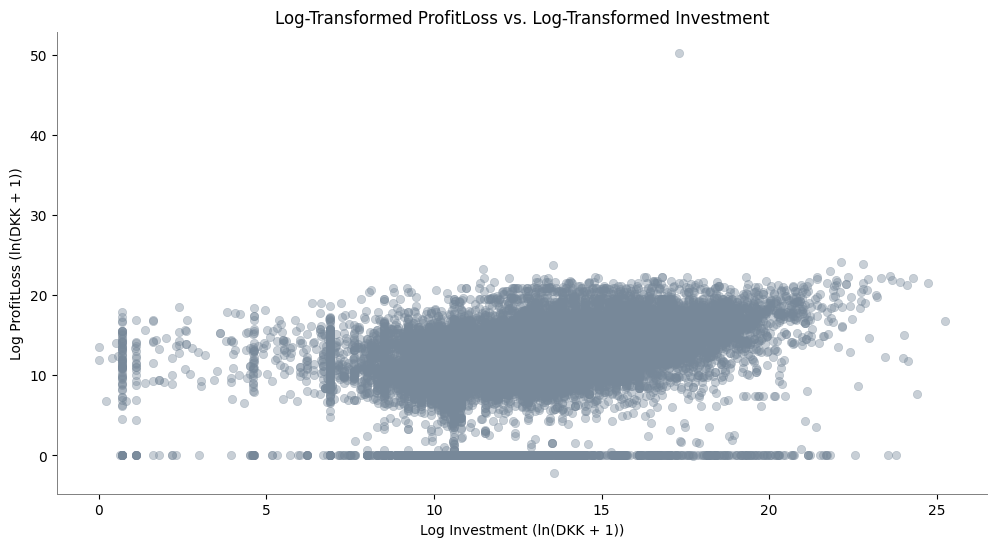

In [234]:
#scatter plot of log-transformed investment vs log-transformed assets
plt.figure(figsize=(12, 6))

investment_range = (0, 1e11)
assets_range = (0, 1e11)

#subset = df_cap_fin.loc[(df_cap_fin.Investment >= investment_range[0]) & (df_cap_fin.Investment <= investment_range[1]) & (df_cap_fin.Assets >= assets_range[0]) & (df_cap_fin.Assets <= assets_range[1])]
subset = df_cap_fin

# Apply log transformation
subset['LogInvestment'] = np.log(subset['Investment'] + 1)  # Adding 1 to avoid log(0)
subset['LogProfitLoss'] = np.log(subset['ProfitLoss'] + 1)  # Adding 1 to avoid log(0)

sns.scatterplot(data=subset, x='LogInvestment', y='LogProfitLoss', color='lightslategray', edgecolor=None, alpha=0.4)
plt.title('Log-Transformed ProfitLoss vs. Log-Transformed Investment')
plt.ylabel('Log ProfitLoss (ln(DKK + 1))')
plt.xlabel('Log Investment (ln(DKK + 1))')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


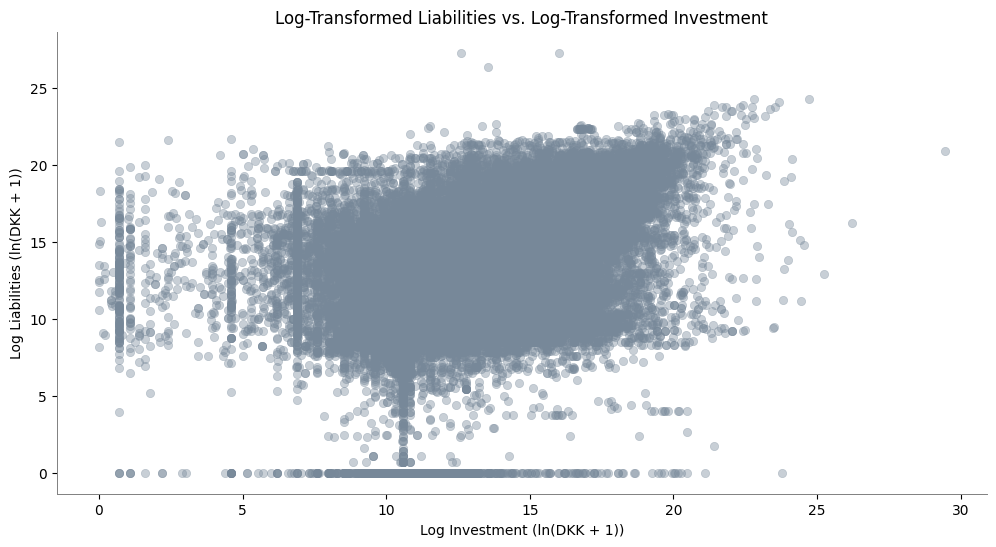

In [235]:
#scatter plot of log-transformed investment vs log-transformed assets
plt.figure(figsize=(12, 6))

investment_range = (0, 1e11)
assets_range = (0, 1e11)

#subset = df_cap_fin.loc[(df_cap_fin.Investment >= investment_range[0]) & (df_cap_fin.Investment <= investment_range[1]) & (df_cap_fin.Assets >= assets_range[0]) & (df_cap_fin.Assets <= assets_range[1])]
subset = df_cap_fin

# Apply log transformation
subset['LogInvestment'] = np.log(subset['Investment'] + 1)  # Adding 1 to avoid log(0)
subset['LogLiabilities'] = np.log(subset['LiabilitiesOtherThanProvisions'] + 1)  # Adding 1 to avoid log(0)

sns.scatterplot(data=subset, x='LogInvestment', y='LogLiabilities', color='lightslategray', edgecolor=None, alpha=0.4)
plt.title('Log-Transformed Liabilities vs. Log-Transformed Investment')
plt.ylabel('Log Liabilities (ln(DKK + 1))')
plt.xlabel('Log Investment (ln(DKK + 1))')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabramslow/Documents/Company2Vec/myvenv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


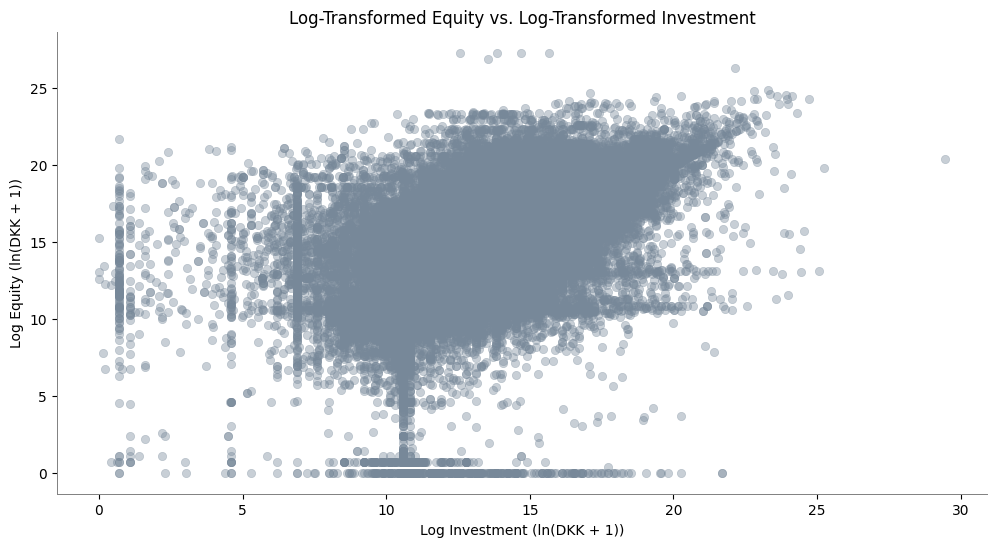

In [236]:
#scatter plot of log-transformed investment vs log-transformed assets
plt.figure(figsize=(12, 6))

investment_range = (0, 1e11)
assets_range = (0, 1e11)

#subset = df_cap_fin.loc[(df_cap_fin.Investment >= investment_range[0]) & (df_cap_fin.Investment <= investment_range[1]) & (df_cap_fin.Assets >= assets_range[0]) & (df_cap_fin.Assets <= assets_range[1])]
subset = df_cap_fin

# Apply log transformation
subset['LogInvestment'] = np.log(subset['Investment'] + 1)  # Adding 1 to avoid log(0)
subset['LogEquity'] = np.log(subset['Equity'] + 1)  # Adding 1 to avoid log(0)

sns.scatterplot(data=subset, x='LogInvestment', y='LogEquity', color='lightslategray', edgecolor=None, alpha=0.4)
plt.title('Log-Transformed Equity vs. Log-Transformed Investment')
plt.ylabel('Log Equity (ln(DKK + 1))')
plt.xlabel('Log Investment (ln(DKK + 1))')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

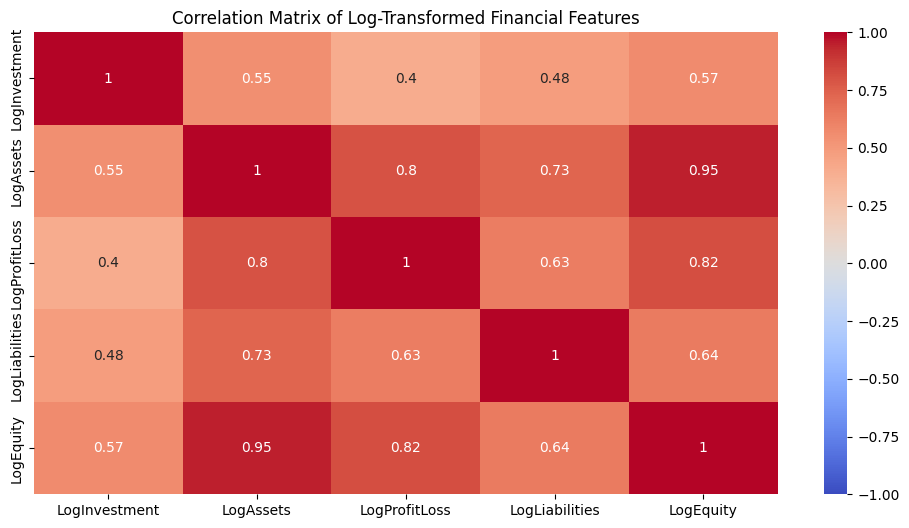

In [237]:
#compute correlation matrix for the subset log-transformed data
corr = subset[['LogInvestment', 'LogAssets', 'LogProfitLoss', 'LogLiabilities', 'LogEquity']].corr()

#plot the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Log-Transformed Financial Features')
plt.show()